In [1]:
library('SGL')
library('grpregOverlap')
library('MASS')
library('glmnet')
library('parallel')

Loading required package: Matrix
Loading required package: grpreg

Attaching package: ‘MASS’

The following object is masked from ‘package:grpregOverlap’:

    select

The following object is masked from ‘package:grpreg’:

    select

Loading required package: foreach
Loaded glmnet 2.0-16



In [2]:
df <- read.csv('/projects/leelab2/data/AD_DATA/simulatedData/corLatentData/df0.csv', header=TRUE)
df = as.data.frame(df)
numPheno <- 1
numGenes <- 2999
numSamples <- 500
numPaths <- 20

In [3]:
df_t = as.data.frame(t(df))
colnames(df_t) = c(paste('p', sep='', 1:numPheno), paste('g', sep='', 1:numGenes))
data_mat = df_t[1:numSamples, ]

In [4]:
bin_path_mat <- df[paste('pathway', 0:(numPaths-1), sep='')]
bin_path_mat <- bin_path_mat[-1, ]

In [5]:
group_index <- integer(numGenes) - 1
group_obj <- which(bin_path_mat == 1, arr.ind=T)
group_index[as.vector(group_obj[, 1])] <- as.vector(group_obj[, 2])

In [6]:
y <- data_mat$p1
x <- data.matrix(data_mat[, paste('g', sep='', 1:numGenes)])

In [7]:
head(x)

,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,⋯,g2990,g2991,g2992,g2993,g2994,g2995,g2996,g2997,g2998,g2999
X0,-1.5629509,-6.328167,4.918395,-3.8785188,1.52304584,0.01924819,-1.554705,1.3218619,-3.23178450,-0.1270229,⋯,-2.515240,-0.2014522,-3.344730,2.1418193,2.7575105,-0.9670143,-0.8508906,-2.4654806,1.7118655,0.9440689
X1,1.6246402,-5.862356,2.383362,-6.3337186,-6.14505201,-3.68435918,-5.884112,-2.0738483,-0.06172857,-0.9868279,⋯,-2.132301,4.4913966,4.985421,-7.4642359,5.9411323,2.8449759,-2.6383309,3.8280864,-1.7499010,-3.7506476
X2,0.6446129,1.862584,2.751587,0.4487882,1.30019296,-0.27388784,5.913832,5.9427777,-1.41858882,-4.0539614,⋯,-3.099782,2.4109552,-4.182873,7.4215098,0.8381763,-6.2138083,-0.6451277,-4.0013592,1.1368586,2.0895018
X3,0.8140002,3.753136,3.086028,1.2297868,0.07036305,1.28322348,-3.007742,-2.2083192,-1.24707006,1.8042356,⋯,-1.555387,-1.8149714,1.536912,-0.3837959,1.9271833,0.1006063,-1.5056058,-2.3487084,2.0438020,-0.3700644
X4,-1.3072558,-5.606119,2.075183,-4.3216323,-3.08568535,2.69829835,-2.178754,-0.2198663,-1.23226305,4.5551511,⋯,-1.777059,1.7806207,-2.069905,-5.1585180,5.6113878,-0.4403290,-5.8948786,-0.4807302,2.0302958,0.6448589
X5,-4.8125905,-1.792568,4.704017,-3.2308474,-1.14910135,-1.99202998,1.058606,5.3436443,-0.61799469,1.7265238,⋯,-4.422610,5.2876729,-4.197060,-1.6631459,-0.4267052,-0.4881859,-1.4083578,-1.7170670,-0.2274963,-2.3139012


In [8]:
dim(x)

[1]  500 2999

In [9]:
filtered_group_index <- group_index[group_index != -1]
filtered_x <- x[, which(group_index != -1)]

In [10]:
alphalist <- seq(0,1,by=0.1)
elasticnet <- lapply(alphalist, function(a){
  cv.glmnet(x, y, alpha=a)
})

In [11]:
elasticnet_df <- data.frame('lambda.min' = as.numeric(unlist(lapply(elasticnet, function(o) {o$lambda.min}))), 
                            'cvm' = as.numeric(unlist(lapply(elasticnet, function(o) {
                                o$cvm[o$lambda == o$lambda.min]}))),
                            'cvsd' = as.numeric(unlist(lapply(elasticnet, function(o) {
                                o$cvsd[o$lambda == o$lambda.min]}))),
                            'alpha' = alphalist)

In [12]:
elasticnet_df

lambda.min,cvm,cvsd,alpha
20.31837193,0.048071524,0.0045027062,0.0
0.20318372,0.008189144,0.0007313730,0.1
0.10642923,0.007889695,0.0006461963,0.2
0.07787063,0.008382736,0.0005890886,0.3
0.05840298,0.007919453,0.0007721389,0.4
0.04894710,0.008414761,0.0008276503,0.5
0.04078925,0.008151472,0.0006750171,0.6
0.03496222,0.008056961,0.0003954348,0.7
0.03204860,0.008196661,0.0008415115,0.8
0.02848764,0.008121007,0.0005202871,0.9


In [13]:
typeof(elasticnet_df$alpha)

[1] "double"

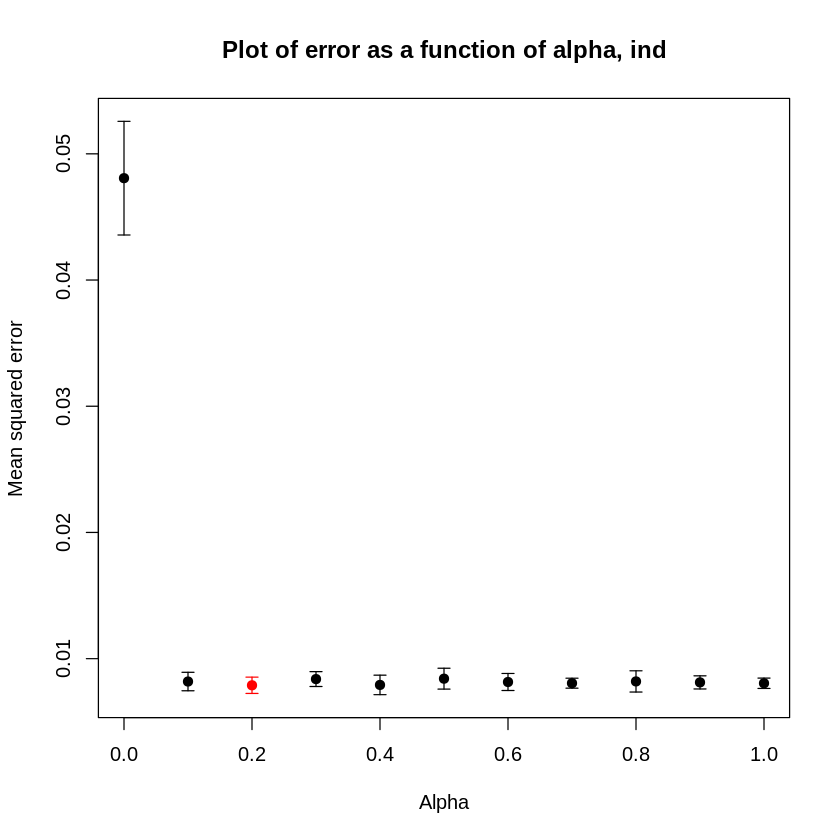

In [14]:
best_alpha <- elasticnet_df[elasticnet_df$cvm == min(elasticnet_df$cvm),]$alpha
best_lambda <- elasticnet_df[elasticnet_df$cvm == min(elasticnet_df$cvm),]$lambda.min
plot(elasticnet_df$alpha, elasticnet_df$cvm,
     ylim=range(c(elasticnet_df$cvm-elasticnet_df$cvsd, elasticnet_df$cvm+elasticnet_df$cvsd)),
     pch=19, xlab="Alpha", ylab="Mean squared error",
     main="Plot of error as a function of alpha, ind",
     col=ifelse(elasticnet_df$alpha==best_alpha, "red", "black")
    )
arrows(elasticnet_df$alpha, elasticnet_df$cvm-elasticnet_df$cvsd, 
       elasticnet_df$alpha, elasticnet_df$cvm+elasticnet_df$cvsd, 
       length=0.05, angle=90, code=3,
       col=ifelse(elasticnet_df$alpha==best_alpha, "red", "black"))

In [15]:
cat(sprintf('Elastic net: best alpha = %f, best lambda = %f', best_alpha, best_lambda))

Elastic net: best alpha = 0.200000, best lambda = 0.106429

In [ ]:
alphalist <- seq(0,1,by=0.1)
sparse_gl <- lapply(alphalist, function(a){
  cvSGL(data=list(x=filtered_x, y=y), index=filtered_group_index, type="linear", alpha=a)
})

In [19]:
sparse_gl_df <- data.frame('lambda.min' = as.numeric(unlist(lapply(sparse_gl, function(o) {
                            o$lambdas[o$lldiff == min(o$lldiff)]}))), 
                            'nll' = as.numeric(unlist(lapply(sparse_gl, function(o) {
                                min(o$lldiff)}))),
                            'nllsd' = as.numeric(unlist(lapply(sparse_gl, function(o) {
                                o$llSD[o$lldiff == min(o$lldiff)]}))),
                            'alpha' = seq(0,1,by=0.1))
sparse_gl_df

ERROR: Error in lapply(sparse_gl, function(o) {: object 'sparse_gl' not found


In [20]:
best_alpha_sgl <- sparse_gl_df[sparse_gl_df$nll == min(sparse_gl_df$nll),]$alpha
best_lambda_sgl <- sparse_gl_df[sparse_gl_df$nll == min(sparse_gl_df$nll),]$lambda.min
plot(sparse_gl_df$alpha, sparse_gl_df$nll,
     ylim=range(c(sparse_gl_df$nll-sparse_gl_df$nllsd, sparse_gl_df$nll+sparse_gl_df$nllsd)),
     pch=19, xlab="Alpha", ylab="Negative Log Likelihood",
     main="Plot of error as a function of alpha, ind",
     col=ifelse(sparse_gl_df$alpha==best_alpha_sgl, "red", "black")
    )
arrows(sparse_gl_df$alpha, sparse_gl_df$nll-sparse_gl_df$nllsd,
       sparse_gl_df$alpha, sparse_gl_df$nll+sparse_gl_df$nllsd, 
       length=0.05, angle=90, code=3,
       col=ifelse(sparse_gl_df$alpha==best_alpha_sgl, "red", "black"))

ERROR: Error in eval(expr, envir, enclos): object 'sparse_gl_df' not found


In [17]:
cat(sprintf('Sparse Group Lasso: best alpha = %f, best lambda = %f', best_alpha_sgl, best_lambda_sgl))

ERROR: Error in sprintf("Sparse Group Lasso: best alpha = %f, best lambda = %f", : object 'best_alpha_sgl' not found
